## Escenarios de migración interna

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# funciones desarrolladas
from functions.agrupar_dfs_censo import *
from functions.cargar_data import *
from functions.impresion import *

# gráficas
import matplotlib.pyplot as plt
from functions.graficas import size_font, hide_spines, metadatos_figs

# 0. Carga modelo

Carga modelo calibrado de statsmodels, guardado como pickle (ver notebook 7). Carga datos de las díada.

In [2]:
prodSim = sm.load('modelos/restringido_origen_mvo.pickle')
prodSim

In [3]:
# carga datos diádicos
dd_deptos = cargar_dd_deptos()
print(dd_deptos.shape)
print(dd_deptos.columns)
dd_deptos.head()

(342, 46)
Index(['cod', 'depto_origen', 'depto_destino', 'personas_mig',
       'personas_mig_18_25', 'personas_mig_26_35', 'personas_mig_100k',
       'pob_origen', 'pob_destino', 'dist', 'dist_km', 'pbi_origen',
       'pbi_porcen_ori', 'pbi_destino', 'pbi_porcen_des',
       'pbi_origen_millardos', 'pbi_destino_millardos', 'largo_limite',
       'dummy_limit', 'empresas_origen', 'empresas_destino',
       'menores_25_origen', 'menores_25_destino', 'pob_destino_k',
       'pob_origen_k', 'nom_depto_orig', 'nom_depto_des', 'edad_prom_ori',
       'porc_ocupados_ori', 'edad_prom_des', 'porc_ocupados_des',
       'tasa_desemp_mujeres_2011_ori', 'tasa_desemp_varones_2011_ori',
       'tasa_desemp_total_2011_ori', 'tasa_desemp_mujeres_2011_des',
       'tasa_desemp_varones_2011_des', 'tasa_desemp_total_2011_des',
       'log_pbi_destino', 'log_dist_km', 'log_pbi_origen_millardos',
       'log_pbi_destino_millardos', 'log_pob_destino_k', 'log_pob_origen_k',
       'log_edad_prom_des', 'log

,cod,depto_origen,depto_destino,personas_mig,personas_mig_18_25,personas_mig_26_35,personas_mig_100k,pob_origen,pob_destino,dist,...,tasa_desemp_total_2011_des,log_pbi_destino,log_dist_km,log_pbi_origen_millardos,log_pbi_destino_millardos,log_pob_destino_k,log_pob_origen_k,log_edad_prom_des,log_porc_ocupados_des,largo_limite_km
0,102,1,2,914,114,247,891,1318755,73377,610726,...,8.1,16.469807,6.415097,6.143859,2.654298,4.295611,7.184443,3.525387,4.151677,1.000000e-07
1,302,3,2,74,9,22,70,520173,73377,601915,...,8.1,16.469807,6.400257,4.457899,2.654298,4.295611,6.254161,3.525387,4.151677,1.000000e-07
2,402,4,2,15,0,6,14,84698,73377,406694,...,8.1,16.469807,6.008813,2.836092,2.654298,4.295611,4.439092,3.525387,4.151677,1.000000e-07
3,502,5,2,28,7,8,25,123203,73377,556292,...,8.1,16.469807,6.320768,3.779383,2.654298,4.295611,4.813833,3.525387,4.151677,1.000000e-07
4,602,6,2,32,0,10,29,57084,73377,446123,...,8.1,16.469807,6.100319,2.566794,2.654298,4.295611,4.044524,3.525387,4.151677,1.000000e-07


# 1. Escenario 1

El primer escenario considera sólo cambios en el PBI. Dado que no se cuenta con estimaciones actualizadas del PBI departamental, se asume un crecimiento uniforme entre los departamentos, es decir se aplica un mismo valor de crecimiento para cada departamento, a partir del crecimiento acumulado 2015-2020, según los datos originales de 2014 calculados por OPP y los datos de crecimiento el PBI de Uruguay reportados por el Banco Mundial.

Lo ideal para este escenario sería contar con nuevos datos de PBI departamental, estimados con un metodología similar a la aplicada por OPP.

In [4]:
pbi = recuperar_crecimiento_pbi()
pbi

,año,pbi_porc
0,2015,0.37
1,2016,1.69
2,2017,1.63
3,2018,0.48
4,2019,0.35
5,2020,-6.00
6,2021,2.00


In [5]:
print(pbi.to_markdown(index=False))

|   año |   pbi_porc |
|------:|-----------:|
|  2015 |       0.37 |
|  2016 |       1.69 |
|  2017 |       1.63 |
|  2018 |       0.48 |
|  2019 |       0.35 |
|  2020 |      -6    |
|  2021 |       2    |


In [6]:
crecimiento_acum = round(pbi.pbi_porc.sum(), 3)
print('Crecimiento acumulado del PBI entre 2015 y 2021: ', crecimiento_acum)

Crecimiento acumulado del PBI entre 2015 y 2021:  0.52


In [7]:
pbi.pbi_porc.values

array([ 0.37,  1.69,  1.63,  0.48,  0.35, -6.  ,  2.  ])

In [8]:
g = pbi.pbi_porc.values/100
g

array([ 0.0037,  0.0169,  0.0163,  0.0048,  0.0035, -0.06  ,  0.02  ])

In [9]:
def calc_pbi(series, pbi_porc):
    "Estima PBI en base a crecimiento anual reportado"
    series_pond = series
    for i in pbi_porc:
        series_pond =+ series_pond + (series_pond * i)

    return round(series_pond).astype(int)

In [10]:
pbi_dest = dd_deptos.drop_duplicates('depto_destino')
pbi_dest = pbi_dest.loc[:, ['depto_destino', 'pbi_destino_millardos']]
pbi_dest.head()

,depto_destino,pbi_destino_millardos
0,2,14.215
18,3,86.306
36,4,17.049
54,5,43.789
72,6,13.024


In [11]:
# proyecta PBI
pbi_dest['pbi_destino_millardos_2021'] = calc_pbi(pbi_dest.pbi_destino_millardos, g)
pbi_dest.tail()


,depto_destino,pbi_destino_millardos,pbi_destino_millardos_2021
252,16,26.931,27
270,17,22.994,23
288,18,18.094,18
306,19,11.721,12
324,1,465.848,467


In [12]:
pbi_dest.drop('pbi_destino_millardos', inplace=True, axis=1)
dd_deptos = dd_deptos.merge(pbi_dest, left_on='depto_destino', right_on='depto_destino')
dd_deptos['log_pbi_destino_millardos'] = np.log(dd_deptos.pbi_destino_millardos_2021)
dd_deptos.head()

,cod,depto_origen,depto_destino,personas_mig,personas_mig_18_25,personas_mig_26_35,personas_mig_100k,pob_origen,pob_destino,dist,...,log_pbi_destino,log_dist_km,log_pbi_origen_millardos,log_pbi_destino_millardos,log_pob_destino_k,log_pob_origen_k,log_edad_prom_des,log_porc_ocupados_des,largo_limite_km,pbi_destino_millardos_2021
0,102,1,2,914,114,247,891,1318755,73377,610726,...,16.469807,6.415097,6.143859,2.639057,4.295611,7.184443,3.525387,4.151677,1.000000e-07,14
1,302,3,2,74,9,22,70,520173,73377,601915,...,16.469807,6.400257,4.457899,2.639057,4.295611,6.254161,3.525387,4.151677,1.000000e-07,14
2,402,4,2,15,0,6,14,84698,73377,406694,...,16.469807,6.008813,2.836092,2.639057,4.295611,4.439092,3.525387,4.151677,1.000000e-07,14
3,502,5,2,28,7,8,25,123203,73377,556292,...,16.469807,6.320768,3.779383,2.639057,4.295611,4.813833,3.525387,4.151677,1.000000e-07,14
4,602,6,2,32,0,10,29,57084,73377,446123,...,16.469807,6.100319,2.566794,2.639057,4.295611,4.044524,3.525387,4.151677,1.000000e-07,14


In [13]:
pbi_dest.to_csv('tablas/pbi_2021.csv', index=False)

In [14]:
pred = prodSim.get_prediction(dd_deptos)

In [15]:
dd_deptos['prodsimest'] = pred.summary_frame()['mean'].round(0).astype(int)
dd_deptos['prodsimest']

0       584
1        84
2        96
3        57
4        52
       ... 
337    2314
338    1779
339    2009
340    1217
341    1693
Name: prodsimest, Length: 342, dtype: int32

In [16]:
# matriz de los valores estimados
esc1 = pd.pivot_table(dd_deptos,
                      values='prodsimest',
                      index='depto_origen',
                      columns='depto_destino',
                      fill_value=0,
                      aggfunc=sum)

esc1

depto_destino,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
depto_origen,,,,,,,,,,,,,,,,,,,
1,0,584,32017,825,2676,1042,529,1924,1295,4962,1389,1121,967,966,1301,4221,1348,980,674
2,1693,0,579,139,206,103,49,106,80,270,273,170,355,89,439,166,159,215,82
3,13420,84,0,122,356,153,78,303,204,751,200,160,139,145,187,517,193,142,101
4,1641,96,580,0,165,102,42,104,99,317,150,103,197,118,176,148,110,156,163
5,2142,57,680,66,0,95,63,112,71,248,165,155,90,64,144,253,215,92,48
6,1524,52,533,75,173,0,71,122,70,212,128,98,91,61,117,156,116,105,59
7,627,20,219,25,93,57,0,46,24,80,61,48,33,21,50,78,61,38,19
8,1932,37,725,53,141,84,39,0,75,231,89,68,62,55,81,188,78,66,44
9,1562,33,588,60,107,57,25,90,0,357,71,53,56,76,67,122,61,55,56


# 2. Escenario 2

In [17]:
dd_deptos = cargar_dd_deptos()
dd_deptos.loc[dd_deptos.depto_destino==6, 'porc_ocupados_des'] = 100

pred = prodSim.get_prediction(dd_deptos)

In [18]:
dd_deptos.head()

,cod,depto_origen,depto_destino,personas_mig,personas_mig_18_25,personas_mig_26_35,personas_mig_100k,pob_origen,pob_destino,dist,...,tasa_desemp_total_2011_des,log_pbi_destino,log_dist_km,log_pbi_origen_millardos,log_pbi_destino_millardos,log_pob_destino_k,log_pob_origen_k,log_edad_prom_des,log_porc_ocupados_des,largo_limite_km
0,102,1,2,914,114,247,891,1318755,73377,610726,...,8.1,16.469807,6.415097,6.143859,2.654298,4.295611,7.184443,3.525387,4.151677,1.000000e-07
1,302,3,2,74,9,22,70,520173,73377,601915,...,8.1,16.469807,6.400257,4.457899,2.654298,4.295611,6.254161,3.525387,4.151677,1.000000e-07
2,402,4,2,15,0,6,14,84698,73377,406694,...,8.1,16.469807,6.008813,2.836092,2.654298,4.295611,4.439092,3.525387,4.151677,1.000000e-07
3,502,5,2,28,7,8,25,123203,73377,556292,...,8.1,16.469807,6.320768,3.779383,2.654298,4.295611,4.813833,3.525387,4.151677,1.000000e-07
4,602,6,2,32,0,10,29,57084,73377,446123,...,8.1,16.469807,6.100319,2.566794,2.654298,4.295611,4.044524,3.525387,4.151677,1.000000e-07


In [19]:
dd_deptos['prodsimest'] = pred.summary_frame()['mean'].round(0).astype(int)

# matriz de los valores estimados
esc2 = pd.pivot_table(dd_deptos,
                      values='prodsimest',
                      index='depto_origen',
                      columns='depto_destino',
                      fill_value=0,
                      aggfunc=sum)

esc2

depto_destino,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
depto_origen,,,,,,,,,,,,,,,,,,,
1,0,589,31883,826,2669,1043,540,1911,1277,4978,1384,1128,973,953,1289,4215,1348,983,665
2,1691,0,577,139,206,103,50,105,79,271,272,171,357,88,435,166,159,215,81
3,13403,84,0,122,355,153,79,300,202,754,200,161,140,143,185,516,193,142,100
4,1639,96,577,0,165,103,43,104,98,318,150,103,198,117,174,147,110,157,161
5,2139,57,677,66,0,95,64,112,70,249,165,156,90,63,142,253,214,92,47
6,1522,52,531,75,173,0,72,121,69,213,127,99,91,60,116,155,116,106,58
7,626,20,218,25,93,57,0,46,24,80,61,49,34,21,49,78,61,38,18
8,1929,37,722,53,141,84,40,0,74,232,89,68,62,54,81,188,78,66,43
9,1560,34,586,60,107,57,25,90,0,358,70,53,57,75,67,122,61,56,55


In [20]:
diferencia = np.subtract(esc1.values, esc2.values)
diferencia

array([[  0,  -5, 134,  -1,   7,  -1, -11,  13,  18, -16,   5,  -7,  -6,
         13,  12,   6,   0,  -3,   9],
       [  2,   0,   2,   0,   0,   0,  -1,   1,   1,  -1,   1,  -1,  -2,
          1,   4,   0,   0,   0,   1],
       [ 17,   0,   0,   0,   1,   0,  -1,   3,   2,  -3,   0,  -1,  -1,
          2,   2,   1,   0,   0,   1],
       [  2,   0,   3,   0,   0,  -1,  -1,   0,   1,  -1,   0,   0,  -1,
          1,   2,   1,   0,  -1,   2],
       [  3,   0,   3,   0,   0,   0,  -1,   0,   1,  -1,   0,  -1,   0,
          1,   2,   0,   1,   0,   1],
       [  2,   0,   2,   0,   0,   0,  -1,   1,   1,  -1,   1,  -1,   0,
          1,   1,   1,   0,  -1,   1],
       [  1,   0,   1,   0,   0,   0,   0,   0,   0,   0,   0,  -1,  -1,
          0,   1,   0,   0,   0,   1],
       [  3,   0,   3,   0,   0,   0,  -1,   0,   1,  -1,   0,   0,   0,
          1,   0,   0,   0,   0,   1],
       [  2,  -1,   2,   0,   0,   0,   0,   0,   0,  -1,   1,   0,  -1,
          1,   0,   0,   0,  -1

### Comparaciones gráficas

In [21]:
# setea tipo de fuente y tamaño
size, font, font_legend = size_font()
color_spines = 'grey'

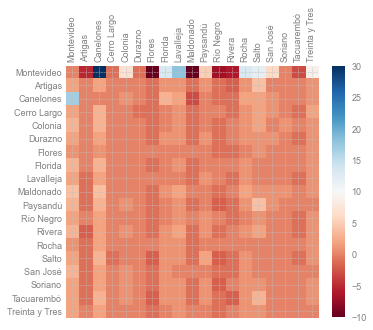

In [24]:
# Escenario 1 vs. Escenario 2

nomdep = cargar_nombres()
fig = plt.figure(figsize=(5, 5))

ax = fig.add_subplot(111)
cax = ax.matshow(diferencia, cmap='RdBu',  vmin=-10, vmax=30)

ax.grid(color='silver', linestyle='--', linewidth=0.5)

plt.xticks(np.arange(0, 19, step=1),
           labels=nomdep, rotation=90, **font, color=color_spines)

plt.yticks(np.arange(0, 19, step=1),
           labels=nomdep, **font, color=color_spines)

ax.tick_params(axis=u'both', which=u'both', length=0)

# color bar
cbar = fig.colorbar(cax, fraction=0.045, drawedges=False)

cbar.outline.set_visible(False)
cbar.ax.tick_params(size=3, color='w', labelsize=size,
                       labelcolor=color_spines)

for l in cbar.ax.yaxis.get_ticklabels():
    l.set_family(font['fontname'])

hide_spines(ax, todos=True)

# save_chart(output_name, metadatos_figs)

plt.show()


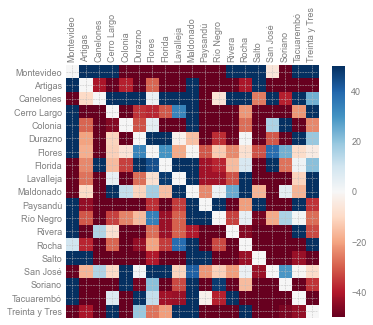

In [32]:
# Groud truth vs. Escenario 2
gt = pd.pivot_table(dd_deptos,
                      values='personas_mig',
                      index='depto_origen',
                      columns='depto_destino',
                      fill_value=0,
                      aggfunc=sum)

diferencia = np.subtract(gt.values, esc2.values)

nomdep = cargar_nombres()
fig = plt.figure(figsize=(5, 5))

ax = fig.add_subplot(111)
cax = ax.matshow(diferencia, cmap='RdBu',  vmin=-50, vmax=50)

ax.grid(color='silver', linestyle='--', linewidth=0.5)

plt.xticks(np.arange(0, 19, step=1),
           labels=nomdep, rotation=90, **font, color=color_spines)

plt.yticks(np.arange(0, 19, step=1),
           labels=nomdep, **font, color=color_spines)

ax.tick_params(axis=u'both', which=u'both', length=0)

# color bar
cbar = fig.colorbar(cax, fraction=0.045, drawedges=False)

cbar.outline.set_visible(False)
cbar.ax.tick_params(size=3, color='w', labelsize=size,
                    labelcolor=color_spines)

for l in cbar.ax.yaxis.get_ticklabels():
    l.set_family(font['fontname'])

hide_spines(ax, todos=True)

# save_chart(output_name, metadatos_figs)

plt.show()
